<a href="https://colab.research.google.com/github/Dhingraakshat/Fraud-detection/blob/main/models/base_models/v33(lightgbm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup: install packages & imports

In [ ]:

!pip -q install optuna lightgbm shap

import os
import json
import random
from collections import Counter

import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    precision_recall_curve,
    recall_score, precision_score, f1_score,
    roc_auc_score, average_precision_score,
    classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import shap

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.6/607.6 kB 44.6 MB/s eta 0:00:00


Mount Google Drive

In [ ]:
# Mount only if running on Colab
try:
    import google.colab  # type: ignore
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# File paths (as you saved them)
PATH_X_TRAIN = "/content/drive/MyDrive/RThesis/X_train_lgb.csv"
PATH_X_TEST  = "/content/drive/MyDrive/RThesis/X_test_lgb.csv"
PATH_Y_TRAIN = "/content/drive/MyDrive/RThesis/y_train.csv"
PATH_Y_TEST  = "/content/drive/MyDrive/RThesis/y_test.csv"

for p in [PATH_X_TRAIN, PATH_X_TEST, PATH_Y_TRAIN, PATH_Y_TEST]:
    if not os.path.exists(p):
        print(f"WARNING: Path does not exist -> {p}")


Mounted at /content/drive


Load data & pick the target column robustly

In [ ]:
def load_csv_clean(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    drop_cols = [c for c in df.columns if c.lower().startswith("unnamed")]
    if drop_cols:
        df = df.drop(columns=drop_cols, errors="ignore")
    return df

X_train = load_csv_clean(PATH_X_TRAIN)
X_test  = load_csv_clean(PATH_X_TEST)
y_train_df = load_csv_clean(PATH_Y_TRAIN)
y_test_df  = load_csv_clean(PATH_Y_TEST)

def pick_target_column(y_df: pd.DataFrame) -> pd.Series:
    if y_df.shape[1] == 1:
        return y_df.iloc[:, 0]
    for cand in ["isFraud","target","label","y","class","outcome"]:
        if cand in y_df.columns:
            return y_df[cand]
    return y_df.iloc[:, -1]

y_train = pick_target_column(y_train_df).copy()
y_test  = pick_target_column(y_test_df).copy()

# --- Force labels to integers {0,1} with POSITIVE = 1 (fraud) ---
def to_zero_one(s: pd.Series) -> pd.Series:
    # If already ints 0/1, return as int
    uniq = pd.Series(s).dropna().unique().tolist()
    if set(uniq).issubset({0,1}) and pd.api.types.is_integer_dtype(s):
        return s.astype(int)

    # Try common mappings
    mapping_candidates = [
        {0:0, 1:1}, {"0":0, "1":1},
        {"False":0, "True":1}, {"false":0, "true":1}
    ]
    for m in mapping_candidates:
        if set(uniq).issubset(set(m.keys())):
            return s.map(m).astype(int)

    # Fallback: make the *minority* value => 1 (fraud), majority => 0
    counts = pd.Series(s).value_counts()
    minority = counts.index[-1]
    return (s == minority).astype(int)

y_train = to_zero_one(y_train)
y_test  = to_zero_one(y_test)

# Fixed semantics
POS_LABEL, NEG_LABEL = 1, 0

# Align test columns to training columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("Shapes:")
print("  X_train:", X_train.shape)
print("  X_test :", X_test.shape)
print("  y_train:", y_train.shape, "value_counts=", dict(pd.Series(y_train).value_counts()))
print("  y_test :", y_test.shape,  "value_counts=", dict(pd.Series(y_test).value_counts()))


Shapes:
  X_train: (472432, 47)
  X_test : (118108, 47)
  y_train: (472432,) value_counts= {0: np.int64(455833), 1: np.int64(16599)}
  y_test : (118108,) value_counts= {0: np.int64(114044), 1: np.int64(4064)}


Define time‑aware CV and helpers

In [ ]:
# IMPORTANT: ensure rows are already sorted chronologically before this split
tscv = TimeSeriesSplit(n_splits=5)

def binarize(y):
    return (pd.Series(y) == POS_LABEL).astype(int).values

def recall_pos(y_true_labels, y_pred_labels):
    y_true_bin = binarize(y_true_labels)
    y_pred_bin = binarize(y_pred_labels)
    return recall_score(y_true_bin, y_pred_bin, zero_division=0)


In [ ]:
# Emphasize recall but avoid degenerate all-positive predictions
BETA = 2.0
prevalence_train = float(y_train.mean())  # fraction of positives
MIN_PRECISION = max(0.05, min(0.25, 2.0 * prevalence_train))  # > baseline prevalence

print(f"Train prevalence (pos=1): {prevalence_train:.4f}")
print(f"Precision floor for thresholding: {MIN_PRECISION:.4f}  (F{BETA:.0f} optimization)\n")

def best_threshold_by_fbeta(y_true, proba, beta=2.0, min_precision=0.05):
    """Choose decision threshold from PR curve that maximizes F-beta
    under a minimum precision constraint."""
    precision, recall, thresholds = precision_recall_curve(y_true, proba)
    p = precision[1:]
    r = recall[1:]
    t = thresholds
    beta2 = beta ** 2

    with np.errstate(divide='ignore', invalid='ignore'):
        fbeta = (1 + beta2) * (p * r) / (beta2 * p + r)
    fbeta = np.nan_to_num(fbeta, nan=0.0, posinf=0.0, neginf=0.0)

    mask = p >= min_precision
    if not np.any(mask):
        idx = int(np.argmax(p))  # fallback: best precision
    else:
        valid_idx = np.where(mask)[0]
        idx = int(valid_idx[np.argmax(fbeta[valid_idx])])

    thr = float(t[idx])
    stats = {"precision": float(p[idx]), "recall": float(r[idx]), "fbeta": float(fbeta[idx])}
    return thr, stats


Train prevalence (pos=1): 0.0351
Precision floor for thresholding: 0.0703  (F2 optimization)



Optuna objective: tune LightGBM (maximize recall)

In [ ]:
# Natural imbalance anchor for scale_pos_weight
n_pos = int((y_train == 1).sum())
n_neg = int((y_train == 0).sum())
base_spw = max(1.0, n_neg / max(1, n_pos))

def make_lgbm_params(trial):
    return {
        "objective": "binary",
        "n_estimators": trial.suggest_int("n_estimators", 400, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256, log=True),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 300),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": 1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 5.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 5.0, log=True),
        # tighter range reduces risk of probability saturation
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5*base_spw, 2.0*base_spw, log=True),
        "verbosity": -1,
        "random_state": SEED,
        "n_jobs": -1,
    }

def objective(trial):
    params = make_lgbm_params(trial)
    fold_f2 = []

    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_train), start=1):
        X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        model = lgb.LGBMClassifier(**params)
        callbacks = [lgb.early_stopping(stopping_rounds=200, verbose=False)]
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="average_precision",  # PR-AUC
            callbacks=callbacks
        )

        proba_pos = model.predict_proba(X_va)[:, list(model.classes_).index(1)]
        thr, stats = best_threshold_by_fbeta(
            y_true=y_va.values,
            proba=proba_pos,
            beta=BETA,
            min_precision=MIN_PRECISION
        )
        fold_f2.append(stats["fbeta"])

        trial.report(float(np.mean(fold_f2)), step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(fold_f2))


Run Optuna study (recall‑focused) and inspect best params

In [ ]:
N_TRIALS = 50  # increase if you have budget/time

study = optuna.create_study(
    direction="maximize",
    study_name="lgbm_f2_timeseries",
    pruner=optuna.pruners.PercentilePruner(25.0)
)
study.optimize(objective, n_trials=N_TRIALS)

print("Best mean CV F2:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


Best mean CV F2: 0.386657424895413
Best params:
  n_estimators: 518
  learning_rate: 0.005072356964221
  num_leaves: 117
  max_depth: -1
  min_child_samples: 123
  feature_fraction: 0.6037282953988325
  bagging_fraction: 0.9752110889325923
  lambda_l1: 1.0269544274927172e-08
  lambda_l2: 0.0010906333657353313
  scale_pos_weight: 13.770018502874905


Train final LightGBM on all training data (time‑aware validation)

In [ ]:
best_params = study.best_params.copy()
final_model = lgb.LGBMClassifier(**best_params)

# Temporal split: first 90% train, last 10% validation (recent)
split_idx = int(len(X_train) * 0.90)
X_tr_final, X_val_final = X_train.iloc[:split_idx], X_train.iloc[split_idx:]
y_tr_final, y_val_final = y_train.iloc[:split_idx], y_train.iloc[split_idx:]

callbacks = [lgb.early_stopping(stopping_rounds=200, verbose=False)]
final_model.fit(
    X_tr_final, y_tr_final,
    eval_set=[(X_val_final, y_val_final)],
    eval_metric="average_precision",
    callbacks=callbacks
)

print(f"Best iteration: {final_model.best_iteration_}")

# Choose global threshold on the recent validation tail
proba_pos_val = final_model.predict_proba(X_val_final)[:, list(final_model.classes_).index(1)]
best_threshold, thr_stats = best_threshold_by_fbeta(
    y_true=y_val_final.values,
    proba=proba_pos_val,
    beta=BETA,
    min_precision=MIN_PRECISION
)
print(f"Chosen global threshold: {best_threshold:.6f}")
print(f"Validation stats at chosen threshold -> precision={thr_stats['precision']:.4f}, recall={thr_stats['recall']:.4f}, F{BETA:.0f}={thr_stats['fbeta']:.4f}")


Best iteration: 19
Chosen global threshold: 0.082160
Validation stats at chosen threshold -> precision=0.1848, recall=0.5048, F2=0.3749


Evaluate on the test set

[TEST] pos_rate=20.79% (prevalence=3.44%)
[TEST] Recall(fraud=1): 0.6585 | Precision: 0.1090 | F1: 0.1870 | ROC-AUC: 0.8200 | PR-AUC: 0.2259

Classification report (positive=fraud=1):
              precision    recall  f1-score   support

not_fraud(0)     0.9852    0.8081    0.8879    114044
    fraud(1)     0.1090    0.6585    0.1870      4064

    accuracy                         0.8030    118108
   macro avg     0.5471    0.7333    0.5374    118108
weighted avg     0.9550    0.8030    0.8638    118108



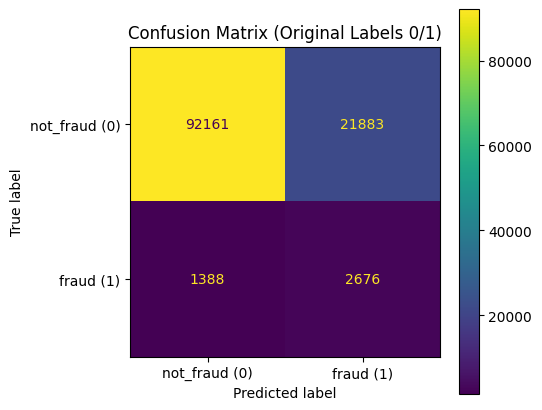

In [ ]:
def evaluate(model, X_te, y_te, threshold):
    proba_pos = model.predict_proba(X_te)[:, list(model.classes_).index(1)]
    y_pred = (proba_pos >= threshold).astype(int)

    pos_rate = float(np.mean(y_pred))
    rec  = recall_score(y_te, y_pred, zero_division=0)
    prec = precision_score(y_te, y_pred, zero_division=0)
    f1   = f1_score(y_te, y_pred, zero_division=0)
    roc  = roc_auc_score(y_te, proba_pos)
    pr   = average_precision_score(y_te, proba_pos)

    print(f"[TEST] pos_rate={pos_rate*100:.2f}% (prevalence={float(np.mean(y_te))*100:.2f}%)")
    print(f"[TEST] Recall(fraud=1): {rec:.4f} | Precision: {prec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")
    print("\nClassification report (positive=fraud=1):")
    print(classification_report(y_te, y_pred, digits=4, zero_division=0, target_names=["not_fraud(0)", "fraud(1)"]))

    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_te, y_pred,
        labels=[0, 1],
        display_labels=["not_fraud (0)", "fraud (1)"],
        ax=ax
    )
    ax.set_title("Confusion Matrix (Original Labels 0/1)")
    plt.show()

    return {"recall": rec, "precision": prec, "f1": f1, "roc_auc": roc, "pr_auc": pr}

test_metrics = evaluate(final_model, X_test, y_test, threshold=0.065)


SHAP summary chart (global feature impact)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/tmp/ipython-input-266177810.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_to_plot, X_shap, show=False)


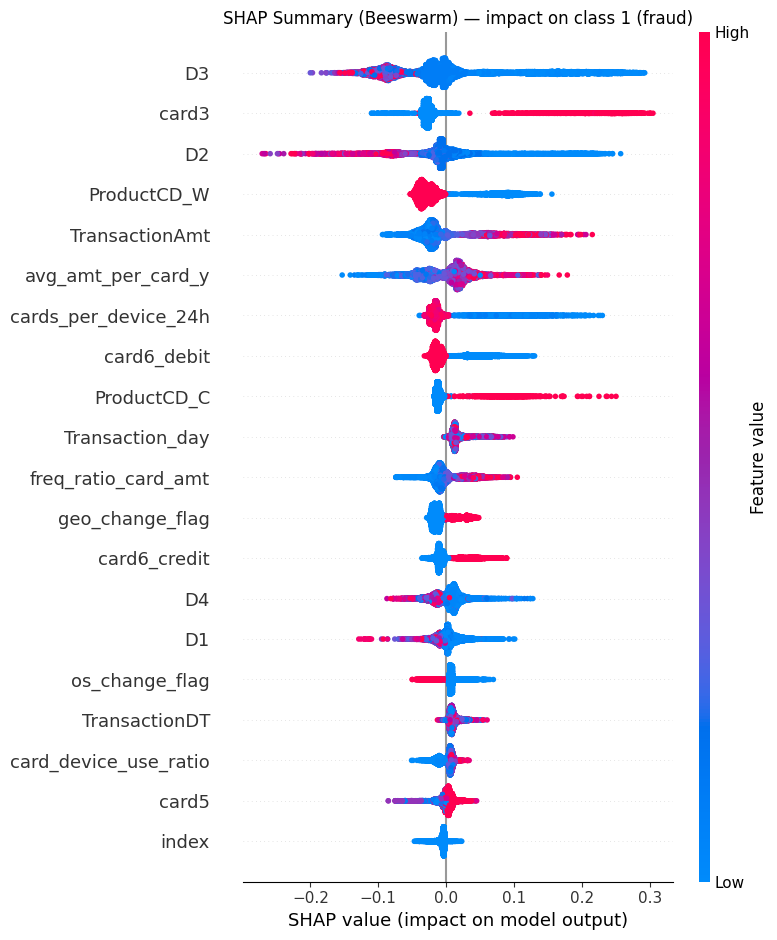

SHAP summary saved to: /content/drive/MyDrive/RThesis/shap_summary.png


In [ ]:
# Sample if huge to keep SHAP fast
MAX_SHAP_ROWS = 10000
X_shap = X_test.iloc[:MAX_SHAP_ROWS].copy()

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_shap)

# For binary models, shap_values may be [neg, pos] -> we want pos (= class 1)
if isinstance(shap_values, list):
    shap_to_plot = shap_values[list(final_model.classes_).index(1)]
else:
    shap_to_plot = shap_values

plt.figure()
shap.summary_plot(shap_to_plot, X_shap, show=False)
plt.title("SHAP Summary (Beeswarm) — impact on class 1 (fraud)")
plt.tight_layout()
shap_out_path = "/content/drive/MyDrive/RThesis/shap_summary.png" if IN_COLAB else "shap_summary.png"
plt.savefig(shap_out_path, dpi=150)
plt.show()
print(f"SHAP summary saved to: {shap_out_path}")


Save model and artifacts

In [ ]:
ART_DIR = "/content/drive/MyDrive/RThesis" if IN_COLAB else "."
os.makedirs(ART_DIR, exist_ok=True)

model_path = os.path.join(ART_DIR, "lgbm_f2_model.txt")
final_model.booster_.save_model(model_path)

with open(os.path.join(ART_DIR, "best_params.json"), "w") as f:
    json.dump(study.best_params, f, indent=2)

with open(os.path.join(ART_DIR, "test_metrics.json"), "w") as f:
    json.dump(test_metrics, f, indent=2)

print("Saved:")
print("  Model       ->", model_path)
print("  Best params ->", os.path.join(ART_DIR, "best_params.json"))
print("  Test metrics->", os.path.join(ART_DIR, "test_metrics.json"))


Saved:
  Model       -> /content/drive/MyDrive/RThesis/lgbm_f2_model.txt
  Best params -> /content/drive/MyDrive/RThesis/best_params.json
  Test metrics-> /content/drive/MyDrive/RThesis/test_metrics.json


Create & save OOF predictions (time‑aware CV with best params)

In [ ]:
def build_oof_predictions(X, y, params, tscv, beta=2.0, min_precision=0.05):
    n = len(X)
    oof = pd.DataFrame({
        "row_id": np.arange(n),
        "y_true": y.values,
        "fold": -1,
        "has_oof": False,
        "pred_label": np.nan,
        "proba_pos": np.nan,
        "threshold_used": np.nan
    })

    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        model = lgb.LGBMClassifier(**params)
        callbacks = [lgb.early_stopping(stopping_rounds=200, verbose=False)]
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="average_precision",
            callbacks=callbacks
        )

        proba_pos = model.predict_proba(X_va)[:, list(model.classes_).index(1)]
        thr, stats = best_threshold_by_fbeta(y_va.values, proba_pos, beta=beta, min_precision=min_precision)
        y_pred = (proba_pos >= thr).astype(int)

        oof.loc[va_idx, "proba_pos"] = proba_pos
        oof.loc[va_idx, "pred_label"] = y_pred
        oof.loc[va_idx, "fold"] = fold
        oof.loc[va_idx, "has_oof"] = True
        oof.loc[va_idx, "threshold_used"] = thr

    oof["pred_label"] = oof["pred_label"].astype("Float64")
    return oof

# Use best iteration if available
# Moved refit_params definition to Zt4xpPorbBs
refit_params = best_params.copy()
best_iter = getattr(final_model, "best_iteration_", None)
if best_iter is not None and best_iter > 0:
    refit_params["n_estimators"] = best_iter

oof_df = build_oof_predictions(
    X=X_train, y=y_train, params=refit_params, tscv=tscv,
    beta=BETA, min_precision=MIN_PRECISION
)

coverage = oof_df["has_oof"].mean()
print(f"OOF coverage: {coverage:.2%}")

OOF_PATH = "/content/drive/MyDrive/RThesis/oof_predictions.csv" if IN_COLAB else "oof_predictions.csv"
oof_df.to_csv(OOF_PATH, index=False)
print(f"Saved OOF predictions to: {OOF_PATH}")

OOF coverage: 83.33%
Saved OOF predictions to: /content/drive/MyDrive/RThesis/oof_predictions.csv


Refit on full training & save in‑sample training predictions

In [ ]:
# Full refit on all training rows
final_model_full = lgb.LGBMClassifier(**refit_params)
final_model_full.fit(X_train, y_train)

proba_pos_train = final_model_full.predict_proba(X_train)[:, list(final_model_full.classes_).index(1)]
pred_label_train = (proba_pos_train >= best_threshold).astype(int)

train_pred_df = pd.DataFrame({
    "row_id": np.arange(len(X_train)),
    "y_true": y_train.values,
    "proba_pos": proba_pos_train,
    "pred_label": pred_label_train,
    "threshold_used": best_threshold
})

TRAIN_PRED_PATH = "/content/drive/MyDrive/RThesis/train_predictions.csv" if IN_COLAB else "train_predictions.csv"
train_pred_df.to_csv(TRAIN_PRED_PATH, index=False)
print(f"Saved training predictions to: {TRAIN_PRED_PATH}")


Saved training predictions to: /content/drive/MyDrive/RThesis/train_predictions.csv


In [ ]:
proba_pos_test = final_model.predict_proba(X_test)[:, list(final_model.classes_).index(1)]
pred_label_test = (proba_pos_test >= best_threshold).astype(int)

test_pred_df = pd.DataFrame({
    "row_id": np.arange(len(X_test)),
    "y_true": y_test.values,
    "proba_pos": proba_pos_test,
    "pred_label": pred_label_test,
    "threshold_used": best_threshold
})

TEST_PRED_PATH = "/content/drive/MyDrive/RThesis/test_predictions.csv" if IN_COLAB else "test_predictions.csv"
test_pred_df.to_csv(TEST_PRED_PATH, index=False)
print(f"Saved test predictions to: {TEST_PRED_PATH}")


Saved test predictions to: /content/drive/MyDrive/RThesis/test_predictions.csv
